In [8]:
import ROOT as r
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backends import backend_pdf
import os

In [9]:
import sqlite3

def readSqlitedb(database="/cvmfs/icarus.opensciencegrid.org/products/icarus/icarus_data/v09_62_00/icarus_data/database/ChannelMapICARUS.db", table="pmt_placements"):

    # Read sqlite query results into a pandas DataFrame
    con = sqlite3.connect(database)
    df = pd.read_sql_query("SELECT * from {}".format(table), con)

    con.close()

    return df

def get_channel_id(db, board, digitizer_channel):
    
    ch = db.loc[(db['digitizer_label']==board) & (db['digitizer_ch_number']==digitizer_channel), ['channel_id']]
    # print(board, ",", digitizer_channel, "-->", ch.values[0][0])

    return ch.values[0][0]

def get_PMT_id(db, channels):
     
    if np.isscalar(channels):
        pmt_id = db[db.channel_id==channels].pmt_id.values[0]
        return pmt_id
    else:
        pmt_ids = [ db[db.channel_id==ch].pmt_id.values[0] for ch in channels ] 
        return pmt_ids

def PMTid_to_channel(pmt_ids):
    
    geo = readSqlitedb()
    
    if np.isscalar(pmt_ids):
        channel = geo[geo.pmt_id==pmt_ids].channel_id.values[0]
        return channel
    else:
        channels = [ geo[geo.pmt_id==pmt].channel_id.values[0] for pmt in pmt_ids ] 
        return channels

geodb = readSqlitedb()

In [10]:
def get_bins_edges(bin_centers):

    bin_edges = []
    bin_edges.append(0.0) #first bin left edge

    for i in range(len(bin_centers)):
        length = 0
        if i == (len(bin_centers)-1):
            length = bin_centers[i]-bin_centers[i-1]
        else:
            length = bin_centers[i+1]-bin_centers[i]
        bin_edges.append(bin_centers[i]+length/2.)

    #print(bin_edges)
    return bin_edges

In [11]:
from scipy.optimize import curve_fit

def poissonGauss(x, amplitude, n, mu, q, sigma ):
    return amplitude*(np.power(mu,n)*np.exp(-1.0*mu)/np.math.factorial(n)*np.exp(-1.0*(x-q*n)*(x-q*n)/(2.0*n*sigma*sigma))/(sigma*np.sqrt(2.0*np.pi*n)))

def IdealSER(x, mu, q, sigma, amplitude):  
    val = 0
    for n in range(1,5): #da 1 a 4
        val += poissonGauss(x, amplitude, n, mu, q, sigma)
    return val

In [12]:
def plot_single_PE_fit_pdf(filedir, PMT, geodb, pdf, max, min):
    
    channel = PMTid_to_channel(PMT)
    print("PMT ID "+str(PMT)+" - Channel ID "+str(channel))
    
    hname = "hintegral"+str(channel)
    hcharge = dir.Get(hname)
    
    binned_events = []
    bin_centers = []
    for i in range(1,hcharge.GetNbinsX()+1):
        binned_events.append(hcharge.GetBinContent(i))
        bin_centers.append(hcharge.GetXaxis().GetBinCenter(i))
    bin_edges = get_bins_edges(bin_centers)
    
    fbin_centers = [x for x in bin_centers if x < max]
    fbin_edges = [x for x in bin_edges if x < max]
    length = len(fbin_centers)
    fbinned_events = binned_events[:length]

    imin = 0
    for i in range(0, length):
        if fbin_centers[i] < min:
            imin = i
        
    xs = fbin_centers[imin+1:]
    ys = fbinned_events[imin+1:]

    param = [ 0.1, 0.45, 0.3, np.max(ys)] # mu, q, sigma, amplitude
    param, pcov = curve_fit(IdealSER, xs, ys, p0=param)#, bounds=(bounds[:,0],bounds[:,1]) )
    param_errors = np.diag(pcov)**0.5
    ys_fitted = IdealSER(xs, *param)

    fig = plt.figure()
    plt.hist(fbin_centers, bins=fbin_edges, weights=fbinned_events, histtype="step", label="Run "+str(run)+" - PMT ID "+str(PMT), lw=1.5)

    lab= "SER fit: \n"
    lab+="$\mu$: %.2f $\pm$ %2.e\n" % ( param[0], param_errors[0] ) 
    lab+="q: %.3f $\pm$ %3.e\n" % ( param[1], param_errors[1] )
    lab+="$\sigma$: %.3f $\pm$ %3.e\n" % ( param[2], param_errors[2] )
    lab+="A: %.0f $\pm$ %.0f\n" % ( param[3], param_errors[3] )
    plt.plot(xs, ys_fitted,'-', lw=2.0, color='red', label=lab)

    plt.grid(color='0.95')
    plt.xlabel(r'Pulse charge [$10^7$ electrons]')
    plt.ylabel("# events")
    plt.title("Single photoelectron charge distribution")
    plt.margins(x=0.00)
    plt.legend()
    
    pdf.savefig( fig )
    plt.close()
    return pdf

def plot_single_PE_fit(filedir, PMT, geodb, max, min):
    
    channel = PMTid_to_channel(PMT)
    print("PMT ID "+str(PMT)+" - Channel ID "+str(channel))
    
    hname = "hintegral"+str(channel)
    hcharge = dir.Get(hname)
    
    binned_events = []
    bin_centers = []
    for i in range(1,hcharge.GetNbinsX()+1):
        binned_events.append(hcharge.GetBinContent(i))
        bin_centers.append(hcharge.GetXaxis().GetBinCenter(i))
    bin_edges = get_bins_edges(bin_centers)
    
    fbin_centers = [x for x in bin_centers if x < max]
    fbin_edges = [x for x in bin_edges if x < max]
    length = len(fbin_centers)
    fbinned_events = binned_events[:length]

    imin = 0
    for i in range(0, length):
        if fbin_centers[i] < min:
            imin = i
        
    xs = fbin_centers[imin+1:]
    ys = fbinned_events[imin+1:]

    param = [ 0.1, 0.45, 0.3, np.max(ys)] # mu, q, sigma, amplitude
    param, pcov = curve_fit(IdealSER, xs, ys, p0=param)#, bounds=(bounds[:,0],bounds[:,1]) )
    param_errors = np.diag(pcov)**0.5
    ys_fitted = IdealSER(xs, *param)

    fig = plt.figure()
    plt.hist(fbin_centers, bins=fbin_edges, weights=fbinned_events, histtype="step", label="PMT ID "+str(PMT), lw=1.5)

    lab= "SER fit: \n"
    lab+="$\mu$: %.2f $\pm$ %2.e\n" % ( param[0], param_errors[0] ) 
    lab+="q: %.3f $\pm$ %3.e\n" % ( param[1], param_errors[1] )
    lab+="$\sigma$: %.3f $\pm$ %3.e\n" % ( param[2], param_errors[2] )
    lab+="A: %.0f $\pm$ %.0f\n" % ( param[3], param_errors[3] )
    plt.plot(xs, ys_fitted,'-', lw=2.0, color='red', label=lab)

    plt.grid(color='0.95')
    plt.xlabel(r'Pulse charge [$10^7$ electrons]')
    plt.ylabel("# events")
    plt.title("Single photoelectron charge distribution")
    plt.margins(x=0.00)
    plt.legend()
    
    return fig

In [17]:
run = 9627
filepath = "/icarus/data/users/mvicenzi/pmt-calibration/analyze_runs/histograms/pulseDistributionHist_run"+str(run)+".root"
#filepath = "/icarus/data/calibration/PMT/equalization/histograms/pulseDistributionHist_run"+str(run)+".root"
file = r.TFile(filepath,"READ")

In [18]:
channel = 93
hname = "hintegral"+str(channel)
dir = file.Get("bkgcalibration")
hcharge = dir.Get(hname)
#hcharge.GetXaxis().SetRangeUser(0.,3.)
#c = r.TCanvas("canvas"+str(channel),"The Canvas Title",800,600)
#hcharge.Draw()
#c.Draw()

PMT ID 93 - Channel ID 265


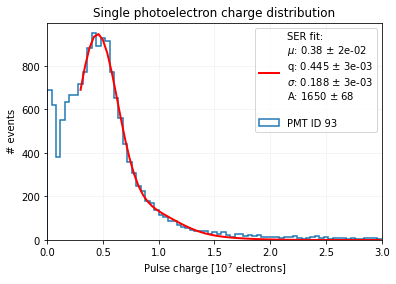

In [19]:
fig = plot_single_PE_fit(dir, channel, geodb, max=3.01, min=0.3)
fig.savefig("../figs/singlePE_charge_run"+str(run)+"_channel"+str(channel)+".png")
fig.savefig("../figs/singlePE_charge_run"+str(run)+"_channel"+str(channel)+".pdf")

In [20]:
offPMTs = [1, 111, 143, 166, 192, 230, 238, 254, 222, 302, 309, 340, 353, 290 ]
ma = 3.01
mi = 0.3

pdf = backend_pdf.PdfPages("../figs/pulse_charge_fits_run"+str(run)+"_min"+str(mi)+"_max"+str(ma)+".pdf")
for PMT in range(1,361):
    
    if PMT in offPMTs:
        continue
    
    try:
        pdf = plot_single_PE_fit_pdf(dir, PMT, geodb, pdf, max=ma, min=mi)
    except:
        continue

print("ALL DONE")
pdf.close()

PMT ID 2 - Channel ID 351
PMT ID 3 - Channel ID 352
PMT ID 4 - Channel ID 353
PMT ID 5 - Channel ID 354
PMT ID 6 - Channel ID 358
PMT ID 7 - Channel ID 356
PMT ID 8 - Channel ID 357
PMT ID 9 - Channel ID 355
PMT ID 10 - Channel ID 359
PMT ID 11 - Channel ID 340
PMT ID 12 - Channel ID 341
PMT ID 13 - Channel ID 342
PMT ID 14 - Channel ID 343
PMT ID 15 - Channel ID 344
PMT ID 16 - Channel ID 348
PMT ID 17 - Channel ID 346
PMT ID 18 - Channel ID 347
PMT ID 19 - Channel ID 345
PMT ID 20 - Channel ID 349
PMT ID 21 - Channel ID 330
PMT ID 22 - Channel ID 331
PMT ID 23 - Channel ID 332
PMT ID 24 - Channel ID 333
PMT ID 25 - Channel ID 334
PMT ID 26 - Channel ID 338
PMT ID 27 - Channel ID 336
PMT ID 28 - Channel ID 337
PMT ID 29 - Channel ID 335
PMT ID 30 - Channel ID 339
PMT ID 31 - Channel ID 320
PMT ID 32 - Channel ID 321
PMT ID 33 - Channel ID 322
PMT ID 34 - Channel ID 323
PMT ID 35 - Channel ID 324
PMT ID 36 - Channel ID 328
PMT ID 37 - Channel ID 326
PMT ID 38 - Channel ID 327
PMT ID 39

PMT ID 312 - Channel ID 49
PMT ID 313 - Channel ID 45
PMT ID 314 - Channel ID 46
PMT ID 315 - Channel ID 47
PMT ID 316 - Channel ID 40
PMT ID 317 - Channel ID 43
PMT ID 318 - Channel ID 44
PMT ID 319 - Channel ID 42
PMT ID 320 - Channel ID 41
PMT ID 321 - Channel ID 38
PMT ID 322 - Channel ID 39
PMT ID 323 - Channel ID 35
PMT ID 324 - Channel ID 36
PMT ID 325 - Channel ID 37
PMT ID 326 - Channel ID 30
PMT ID 327 - Channel ID 33
PMT ID 328 - Channel ID 34
PMT ID 329 - Channel ID 32
PMT ID 330 - Channel ID 31
PMT ID 331 - Channel ID 28
PMT ID 332 - Channel ID 29
PMT ID 333 - Channel ID 25
PMT ID 334 - Channel ID 26
PMT ID 335 - Channel ID 27
PMT ID 336 - Channel ID 20
PMT ID 337 - Channel ID 23
PMT ID 338 - Channel ID 24
PMT ID 339 - Channel ID 22
PMT ID 341 - Channel ID 18
PMT ID 342 - Channel ID 19
PMT ID 343 - Channel ID 15
PMT ID 344 - Channel ID 16
PMT ID 345 - Channel ID 17
PMT ID 346 - Channel ID 10
PMT ID 347 - Channel ID 13
PMT ID 348 - Channel ID 14
PMT ID 349 - Channel ID 12
P